# **<center><font style="color:rgb(100,109,254)">Real-Time 3D Pose Detection & Pose Classification with Mediapipe and Python</font> </center>**
This is basically the implementation of Yoga Pose Correction by making the dataset for the same using the Mediapipe

Pose Detection (also known as Pose Estimation) is a widely used computer vision task that enables you to predict humans poses in images or videos by localizing the key body joints (also reffered  as landmarks), these are elbows, shoulders, and knees, etc. 

<img src='https://drive.google.com/uc?export=download&id=1hT-lhDvzft8vVQv6ObSok73h7A4l5CXf'>


[MediaPipe](https://google.github.io/mediapipe/solutions/pose.html) provides a robust solution capable of predicting **thirty-three 3D landmarks** on a human body in real-time with high accuracy even on CPU. It utilizes a two-step machine learning pipeline, by using a detector it first localizes the person within the frame and then uses the pose landmarks detector to predict the  landmarks within the region of interest.


<img src='https://drive.google.com/uc?export=download&id=1c1vFXlRbN9r4ONKIE3sEmaLsWEfm2vpF'>


For the videos, the detector is used only for the very first frame and then the ROI(Region of Interest) is derived from the previous frame’s pose landmarks using a tracking method. Also when the tracker loses track of the identify body pose presence in a frame, the detector is invoked again for the next frame which reduces the computation and latency. The image below shows the thirty-three pose landmarks along with their indexes.

<img src="https://drive.google.com/uc?export=download&id=1CDO0KiXZEOuWc7xLEm7EFLLQf2hydCoI">

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

Let's start by importing the required libraries.

In [56]:
import math
import cv2
import numpy as np
import pandas as pd
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import os

In [26]:
# Setting up the path for the images
path1 = 'DataSet/Train/goddess'
path2 = 'DataSet/Train/mountain'
path3 = 'DataSet/Train/plank'
path4 = 'DataSet/Train/tree'
dir1 = os.listdir(path1)
dir2 = os.listdir(path2)
dir3 = os.listdir(path3)
dir4 = os.listdir(path4)

In [29]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

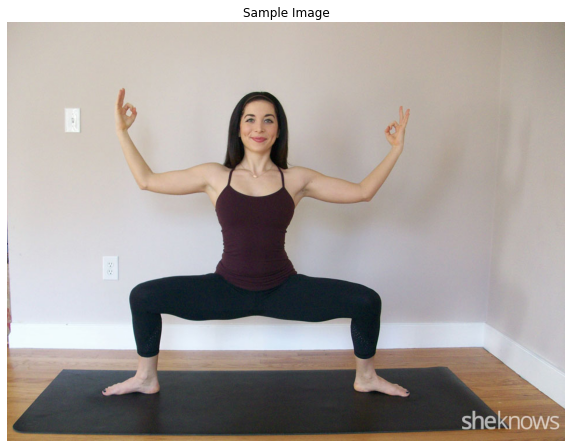

In [27]:
# Read an image from the specified path.
sample_img = cv2.imread(path1 + '/'+dir[0])

# Specify a size of the figure.
plt.figure(figsize = [10, 10])

# Display the sample image, also convert BGR to RGB for display. 
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [13]:
# mp_pose.PoseLandmark(0).name,result.pose_landmarks.landmark[mp_pose.PoseLandmark(0).value]

In [28]:
# Perform pose detection after converting the image into RGB format.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Iterate two times as we only want to display first two landmarks.
    for i in range(2):
        
        # Display the found normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}') 

NOSE:
x: 0.45387566
y: 0.2529126
z: -0.47261626
visibility: 0.9999746

LEFT_EYE_INNER:
x: 0.4641629
y: 0.23743233
z: -0.4424019
visibility: 0.99991107



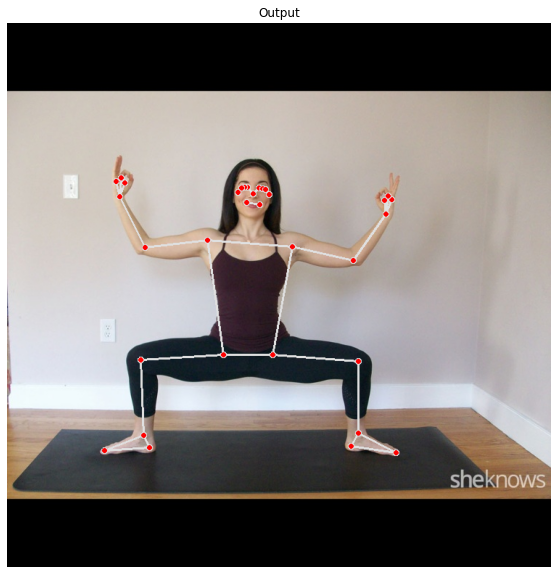

<Figure size 432x288 with 0 Axes>

In [24]:
# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()
    # plt.imsave('goddess.jpg',fig)
    plt.savefig('SAMPLES/goddess.jpg')


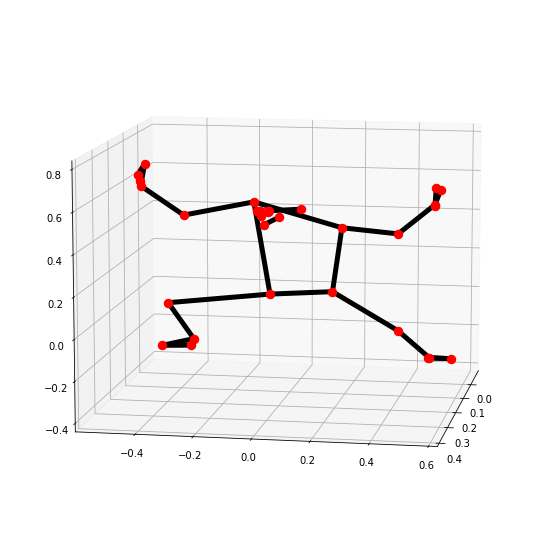

In [25]:
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

**Note:** This is actually a neat hack by mediapipe, the coordinates returned are not actually in **3D** but by setting hip landmark as the origin allows us to measure relative distance of the other points from the hip, and since this distance increases or decreases depending upon if you're close or further from the camera it gives us a sense of depth of each landmark point. 

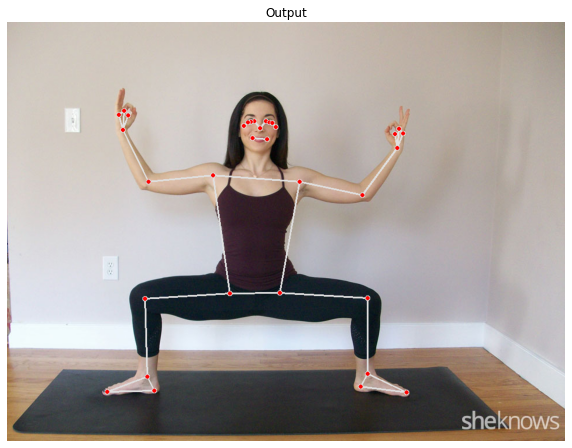

<Figure size 432x288 with 0 Axes>

In [36]:
# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()
    # plt.imsave('goddess.jpg',fig)
    plt.savefig('SAMPLES/goddess.jpg')


In [129]:
df = 0

In [132]:
def appendrow(results):
  '''
  appends the row data of one image into the dataframe
  '''
  main_list = []
  # total_landmark = len(results.pose_landmarks.landmark)
  for i in range(33):
    x = results.pose_landmarks.landmark[i].x
    y = results.pose_landmarks.landmark[i].y
    z = results.pose_landmarks.landmark[i].z
    label = mp_pose.PoseLandmark(i).name
    visibility = results.pose_landmarks.landmark[i].visibility
    main_list.append(x)
    main_list.append(y)
    main_list.append(z)
    main_list.append(visibility)
  return main_list
  

In [173]:
# Entire function for doing the same thing as before as a total detectPose function
# This fn will take the path of the images source and give the output of coordinates 
def giveCoordinates(path, pose, label='Unknown',display=False):
    '''
    This function performs pose detection on an image.
    Args:
        path : The path to the folder to which the images of the needed poses is required
        pose: The pose setup function required to perform the pose detection.
        label: The pose type which is being performed ( by default it will be Unknown )
    Returns:
        coordinates : returns the coordinates of the images in the dataframe
    '''
    x = 0
    i = 0
    dir = os.listdir(path)
    # Create a copy of the input image.
    heading = [mp_pose.PoseLandmark(i).name for i in range(33)]
    columns = ['x','y','z','visibility']
    df = pd.DataFrame(columns=pd.MultiIndex.from_product([heading,columns]))
    # for i in range(len(dir))
    while(i<len(dir)):
        image = cv2.imread(path+'/'+dir[i])
        # Convert the image from BGR into RGB format.
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Perform the Pose Detection.
        results = pose.process(imageRGB)
        if results.pose_landmarks: 
        # Retrieve the height and width of the input image.
        # height, width, _ = image.shape
            main_list = appendrow(results)
            df.loc[x] = main_list  
            i += 1
            x += 1
            print(i,end=' ')
        else:
            i +=1

    df["POSE"] = label.lower()
    return df     
        
        

In [174]:
path1,len(dir1)

('DataSet/Train/goddess', 223)

In [175]:
# pathx = 'DataSet/Train/SAMPLES/'
data1 = giveCoordinates(path1,pose,label='goddess')
data1.head()

1 2 3 4 5 6 7 8 9 10 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50 51 53 54 55 57 58 59 60 61 62 63 64 65 66 67 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 

NOSE                                LEFT_EYE_INNER                      \
          x         y         z visibility              x         y         z   
0  0.453876  0.252913 -0.472616   0.999975       0.464163  0.237432 -0.442402   
1  0.519980  0.355320 -0.289347   0.999996       0.530090  0.340740 -0.251756   
2  0.509743  0.201609 -0.508451   0.999945       0.526056  0.181884 -0.451651   
3  0.533172  0.212420 -0.199738   0.999995       0.544522  0.192830 -0.166439   
4  0.522345  0.382944 -0.296737   0.999996       0.528033  0.368982 -0.269873   

              LEFT_EYE            ... RIGHT_HEEL LEFT_FOOT_INDEX            \
  visibility         x         y  ... visibility               x         y   
0   0.999911  0.470468  0.239012  ...   0.904472        0.715891  0.884679   
1   0.999991  0.535197  0.341645  ...   0.927644        0.777819  0.881344   
2   0.999869  0.536031  0.182447  ...   0.707001        0.917416  0.889308   
3   0.999988  0.552773  0.192220  ...   0.867226        0.851806  0.908260   
4   0.999981  0.533036  0.369597  ...   0.904347        0.761623  0.891259   

                       RIGHT_FOOT_INDEX                                 \
          z visibility                x         y         z visibility   
0 -0.100952   0.957266         0.179942  0.882096 -0.113509   0.908597   
1 -0.175721   0.951836         0.286674  0.877373 -0.185820   0.952968   
2 -0.103027   0.740679         0.068835  0.903598 -0.209253   0.757455   
3 -0.184022   0.901553         0.270159  0.894694 -0.124550   0.876801   
4 -0.166190   0.927221         0.231023  0.880084 -0.170295   0.906651   

      POSE  
            
0  goddess  
1  goddess  
2  goddess  
3  goddess  
4  goddess  

[5 rows x 133 columns]

In [177]:
path2,len(dir2)

('DataSet/Train/mountain', 160)

In [181]:
data2 = giveCoordinates(path2,pose,label='mountain')
data2.tail()

NOSE                                LEFT_EYE_INNER            \
            x         y         z visibility              x         y   
155  0.507228  0.182609 -0.648075   0.999997       0.517291  0.166066   
156  0.491027  0.183240 -0.503216   0.999992       0.502807  0.164589   
157  0.399978  0.087978 -0.545755   0.999931       0.407293  0.072789   
158  0.602017  0.086112 -0.517545   0.999881       0.617143  0.072088   
159  0.486098  0.110481 -0.348074   0.999946       0.495507  0.096792   

                          LEFT_EYE            ... RIGHT_HEEL LEFT_FOOT_INDEX  \
            z visibility         x         y  ... visibility               x   
155 -0.638597   0.999991  0.523011  0.165246  ...   0.562487        0.651225   
156 -0.488704   0.999973  0.509906  0.164653  ...   0.542237        0.469088   
157 -0.505680   0.999793  0.413172  0.073802  ...   0.831552        0.486079   
158 -0.485371   0.999680  0.625898  0.072742  ...   0.817202        0.698429   
159 -0.313012   0.999828  0.502476  0.097560  ...   0.503030        0.552015   

                                   RIGHT_FOOT_INDEX                      \
            y         z visibility                x         y         z   
155  0.934177 -0.060826   0.945691         0.514551  0.948436 -0.169313   
156  0.956374 -0.196115   0.917578         0.338872  0.940834 -0.113775   
157  0.983746  0.211140   0.983683         0.307749  0.982628  0.113742   
158  0.978763  0.187727   0.978504         0.520997  0.979396  0.165685   
159  0.969105  0.013488   0.916990         0.482073  0.978194 -0.063455   

                    POSE  
    visibility            
155   0.942110  mountain  
156   0.912908  mountain  
157   0.976553  mountain  
158   0.970013  mountain  
159   0.883350  mountain  

[5 rows x 133 columns]

In [182]:
path3,len(dir3)

('DataSet/Train/plank', 324)

In [183]:
data3 = giveCoordinates(path3,pose,label='plank')
data3.head()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 

NOSE                                LEFT_EYE_INNER                      \
          x         y         z visibility              x         y         z   
0  0.252461  0.267781 -0.040244   0.999760       0.242139  0.242398 -0.071366   
1  0.151373  0.407567 -0.049630   0.999848       0.137876  0.383861 -0.081811   
2  0.104322  0.557945 -0.222892   0.999993       0.100458  0.525472 -0.255542   
3  0.129644  0.401458  0.090868   0.999916       0.113313  0.376484  0.059572   
4  0.825370  0.732718 -0.260633   0.999999       0.844675  0.730638 -0.229024   

              LEFT_EYE            ... RIGHT_HEEL LEFT_FOOT_INDEX            \
  visibility         x         y  ... visibility               x         y   
0   0.999446  0.242441  0.236325  ...   0.252401        0.786653  0.851341   
1   0.999638  0.138799  0.378771  ...   0.170853        0.778272  0.847300   
2   0.999992  0.104118  0.521679  ...   0.533027        0.900708  0.800927   
3   0.999815  0.113516  0.371398  ...   0.145605        0.828886  0.864773   
4   0.999999  0.845137  0.735832  ...   0.571495        0.070102  0.873610   

                       RIGHT_FOOT_INDEX                                  POSE  
          z visibility                x         y         z visibility         
0 -0.151281   0.972975         0.763183  0.809662  0.212992   0.346294  plank  
1 -0.268392   0.808053         0.772281  0.827211  0.103394   0.177510  plank  
2 -0.011889   0.979697         0.862703  0.771717  0.614084   0.574678  plank  
3 -0.357942   0.696594         0.826655  0.851859  0.035977   0.153146  plank  
4  0.196422   0.274676         0.063427  0.892721 -0.165064   0.592142  plank  

[5 rows x 133 columns]

In [184]:
path4,len(dir4)

('DataSet/Train/tree', 95)

In [185]:
data4 = giveCoordinates(path4,pose,label='tree')
data4

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 

NOSE                                LEFT_EYE_INNER            \
           x         y         z visibility              x         y   
0   0.606693  0.181056 -0.124712   0.999702       0.614720  0.168089   
1   0.564333  0.209852 -0.172451   0.999948       0.571611  0.193136   
2   0.485860  0.135068 -0.141377   0.999942       0.485935  0.117050   
3   0.511258  0.324181  0.096956   0.999992       0.507588  0.313463   
4   0.520800  0.255867 -0.543125   0.998782       0.536114  0.243000   
..       ...       ...       ...        ...            ...       ...   
89  0.519112  0.301349 -0.351910   0.992057       0.530267  0.286043   
90  0.519619  0.254249 -0.323987   0.999281       0.525128  0.235916   
91  0.469464  0.268476 -0.261622   0.999842       0.477506  0.255293   
92  0.487381  0.139820 -0.282067   0.999974       0.497750  0.123232   
93  0.543111  0.328312 -0.283671   0.997369       0.546904  0.305737   

                         LEFT_EYE            ... RIGHT_HEEL LEFT_FOOT_INDEX  \
           z visibility         x         y  ... visibility               x   
0  -0.103244   0.999772  0.622536  0.168387  ...   0.320323        0.574969   
1  -0.147759   0.999962  0.577066  0.192487  ...   0.337287        0.561993   
2  -0.120559   0.999910  0.488110  0.116375  ...   0.936656        0.490941   
3   0.076795   0.999986  0.505559  0.313546  ...   0.907555        0.499055   
4  -0.492409   0.999001  0.548683  0.243299  ...   0.596438        0.518259   
..       ...        ...       ...       ...  ...        ...             ...   
89 -0.314041   0.993196  0.537635  0.285567  ...   0.181742        0.443029   
90 -0.304176   0.999470  0.530010  0.235718  ...   0.285270        0.500092   
91 -0.236008   0.999876  0.482147  0.255321  ...   0.891658        0.481341   
92 -0.247796   0.999960  0.503190  0.123865  ...   0.982045        0.490526   
93 -0.236434   0.997622  0.551666  0.304887  ...   0.608712        0.783001   

                                  RIGHT_FOOT_INDEX                      \
           y         z visibility                x         y         z   
0   0.874075 -0.016806   0.945683         0.610554  0.620491  0.071013   
1   0.909641  0.004252   0.961987         0.566058  0.683520  0.179538   
2   0.672130  0.169583   0.800661         0.494568  0.938652 -0.067218   
3   0.746371  0.075436   0.589745         0.495583  0.967848 -0.017557   
4   0.948273  0.182472   0.943265         0.533739  0.776333 -0.008650   
..       ...       ...        ...              ...       ...       ...   
89  0.955426 -0.238312   0.758940         0.519853  0.740195  0.177027   
90  0.929988  0.128626   0.839827         0.511921  0.690751  0.053647   
91  0.718307  0.201142   0.791203         0.476855  0.979275 -0.009220   
92  0.663215  0.377703   0.947371         0.504019  0.907861  0.062774   
93  0.659048 -0.242592   0.581394         0.887251  0.951476 -0.454714   

               POSE  
   visibility        
0    0.469436  tree  
1    0.520881  tree  
2    0.986504  tree  
3    0.811213  tree  
4    0.720525  tree  
..        ...   ...  
89   0.154724  tree  
90   0.392975  tree  
91   0.958774  tree  
92   0.996728  tree  
93   0.607581  tree  

[94 rows x 133 columns]

In [186]:
combi_df = pd.concat([data1, data2,data3,data4])

In [187]:
combi_df.to_csv('filename.csv')

In [1]:
path = 'DataSet/Train/goddess/'
dir = os.listdir(path)
x = 0
for i in dir:
  name = 'goddess_'
  paths = path + i
  x += 1
  name = name + str(x) + "." +i.split('.')[1]
  pathd = path + name
  os.rename(paths,pathd)
  